In [37]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
import tools

In [38]:
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python')
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py')

In [39]:
warnings.filterwarnings("ignore", category=SyntaxWarning)
import lumapi
modeApi = lumapi.MODE()

In [40]:
#units
nm = 1e-9
um = 1e-6

In [41]:
modeApi.switchtolayout()
modeApi.deleteall()

<h1>Dimensões, materiais e outas especificações do guia (PDK)</h1>

In [42]:
sub_material = 'SiO2 (Glass) - Palik'

gap = 200*nm
x_span_core = 500*nm
x_core = (x_span_core+gap)/2
y_core = 0.0*um
y_span_core = 0.220*um
z_core = 0.0*um
z_core_span = 1.0*um
core_material = 'Si (Silicon) - Palik'

## Objetos do dispositivo

In [43]:
#waveguide
modeApi.addrect()
modeApi.set('name', 'core_1')
modeApi.set('x', -x_core)
modeApi.set('x span', x_span_core)
modeApi.set('y', y_core)
modeApi.set('y span', y_span_core)
modeApi.set('z', z_core)
modeApi.set('z span', z_core_span)
modeApi.set('material', core_material)

modeApi.copy()
modeApi.set('name', 'core_2')
modeApi.set('x', x_core)

Dimensões e características do solver

In [44]:
fde_solve_material = sub_material
x_fde = 0.0
x_span_fde = 4*um
y_fde = 0.0
y_span_fde = 4*um
z_fde = 0.0
z_span_fde = 0*um
mesh_cells = 100
wavelength = 1547.5*nm

startWvg = 1530*nm
stopWvg = 1565*nm
modes = 4
mesh_multiplier = 4

In [45]:
#solver
modeApi.addfde()
modeApi.set('Solver type', '2D Z normal')
modeApi.set('background material', fde_solve_material)

modeApi.set('x', x_fde)
modeApi.set('x span', x_span_fde)
modeApi.set('y', y_fde)
modeApi.set('y span', y_span_fde)
modeApi.set('z', z_fde)

modeApi.set('define x mesh by', 'number of mesh cells')
modeApi.set('define y mesh by', 'number of mesh cells')
modeApi.set('mesh cells x', mesh_cells)
modeApi.set('mesh cells y', mesh_cells)

modeApi.set('wavelength', wavelength)
modeApi.set('number of trial modes', modes)

modeApi.set('fit materials with multi-coefficient model', True)
modeApi.set('wavelength start', startWvg)
modeApi.set('wavelength stop', stopWvg)

modeApi.set('x min bc', 'PML')
modeApi.set('x max bc', 'PML')
modeApi.set('y min bc', 'PML')
modeApi.set('y max bc', 'PML')

#adding mesh
modeApi.addmesh()
modeApi.set('set mesh multiplier', True)
modeApi.set('x', x_fde)
modeApi.set('x span', 0.35*x_span_fde)
modeApi.set('x mesh multiplier', mesh_multiplier)
modeApi.set('y', y_fde)
modeApi.set('y span', 0.15*y_span_fde)
modeApi.set('y mesh multiplier', mesh_multiplier)
modeApi.set('z span', 0)

Determinação dos modos propagantes

In [46]:
nmbOfModes = int(modeApi.findmodes())

In [47]:
eField = np.squeeze(modeApi.getresult('FDE::data::mode1', 'Ex'))
x_efielf = modeApi.getresult('FDE::data::mode1', 'x')/um
y_efielf = modeApi.getresult('FDE::data::mode1', 'y')/um

rfIndex = np.squeeze(modeApi.getdata('FDE::data::material', 'index_y'))

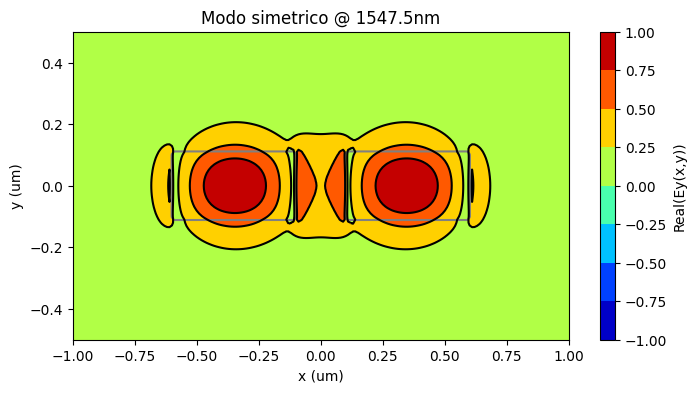

In [48]:
v = np.linspace(-1,1,9, endpoint = True)

fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(111)
X,Y = np.meshgrid(x_efielf, y_efielf)
plt.contour(X,Y,np.rot90(rfIndex.real),0, colors='gray', origin='upper')
plt.contour(X,Y,np.rot90(eField.real),v, colors='k', vmin=-1, vmax=1)
im = plt.contourf(X,Y, np.rot90(eField.real),v, cmap=plt.cm.jet, vmin=-1, vmax=1)

colorbar = plt.colorbar(im)
colorbar.set_ticks(v)
colorbar.set_label(r'Real(Ey(x,y))')
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.title(f'Modo simetrico @ 1547.5nm')
plt.xlim([-1,1])
plt.ylim([-0.5,0.5])

plt.savefig('symmetric_mode.png')

Modo assímetrico

In [49]:
eField = np.squeeze(modeApi.getresult('FDE::data::mode2', 'Ex'))
x_efielf = modeApi.getresult('FDE::data::mode2', 'x')/um
y_efielf = modeApi.getresult('FDE::data::mode2', 'y')/um

rfIndex = np.squeeze(modeApi.getdata('FDE::data::material', 'index_y'))

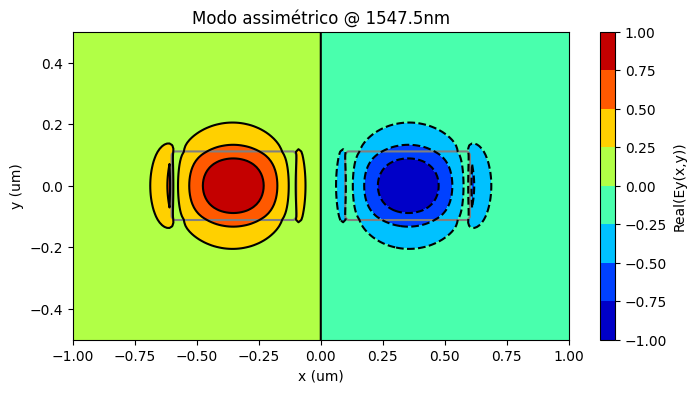

In [50]:
v = np.linspace(-1,1,9, endpoint = True)

fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(111)
X,Y = np.meshgrid(x_efielf, y_efielf)
plt.contour(X,Y,np.rot90(rfIndex.real),0, colors='gray', origin='upper')
plt.contour(X,Y,np.rot90(eField.real),v, colors='k', vmin=-1, vmax=1)
im = plt.contourf(X,Y, np.rot90(eField.real),v, cmap=plt.cm.jet, vmin=-1, vmax=1)

colorbar = plt.colorbar(im)
colorbar.set_ticks(v)
colorbar.set_label(r'Real(Ey(x,y))')
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.title('Modo assimétrico @ 1547.5nm')
plt.xlim([-1,1])
plt.ylim([-0.5,0.5])

plt.savefig('asymmetric_mode.png')

<h1>Acoplamento de potência em função do comprimento do dispositivo</h1>

In [51]:
nplus = modeApi.getresult('FDE::data::mode1', 'neff')
nminus = modeApi.getresult('FDE::data::mode2', 'neff')
L_x = wavelength/(4*np.abs(nplus.real - nminus.real))
L_x/um

array([[19.09381718]])

## Simulação da seção de controle de fase

In [52]:
modeApi.switchtolayout()
modeApi.deleteall()

In [53]:
gap = 200*nm
gap2 = 300*nm
x_span_core_top = 600*nm
x_span_core_bottom = 400*nm
x_core = gap2/2
y_core = 0.0*um
y_span_core = 0.220*um
z_core = 0.0*um
z_core_span = 1.0*um

In [54]:
#waveguide 1
modeApi.addrect()
modeApi.set('name', 'core_1')
modeApi.set('x', -x_core - x_span_core_top/2)
modeApi.set('x span', x_span_core_top)
modeApi.set('y', y_core)
modeApi.set('y span', y_span_core)
modeApi.set('z', z_core)
modeApi.set('z span', z_core_span)
modeApi.set('material', core_material)

#waveguide 2
modeApi.addrect()
modeApi.set('name', 'core_2')
modeApi.set('x', x_core + x_span_core_bottom/2)
modeApi.set('x span', x_span_core_bottom)
modeApi.set('y', y_core)
modeApi.set('y span', y_span_core)
modeApi.set('z', z_core)
modeApi.set('z span', z_core_span)
modeApi.set('material', core_material)

In [55]:
#solver
modeApi.addfde()
modeApi.set('Solver type', '2D Z normal')
modeApi.set('background material', fde_solve_material)

modeApi.set('x', x_fde)
modeApi.set('x span', x_span_fde)
modeApi.set('y', y_fde)
modeApi.set('y span', y_span_fde)
modeApi.set('z', z_fde)

modeApi.set('define x mesh by', 'number of mesh cells')
modeApi.set('define y mesh by', 'number of mesh cells')
modeApi.set('mesh cells x', mesh_cells)
modeApi.set('mesh cells y', mesh_cells)

modeApi.set('wavelength', wavelength)
modeApi.set('number of trial modes', modes)

modeApi.set('fit materials with multi-coefficient model', True)
modeApi.set('wavelength start', startWvg)
modeApi.set('wavelength stop', stopWvg)

modeApi.set('x min bc', 'PML')
modeApi.set('x max bc', 'PML')
modeApi.set('y min bc', 'PML')
modeApi.set('y max bc', 'PML')

#adding mesh
modeApi.addmesh()
modeApi.set('set mesh multiplier', True)
modeApi.set('x', x_fde)
modeApi.set('x span', 0.4*x_span_fde)
modeApi.set('x mesh multiplier', mesh_multiplier)
modeApi.set('y', y_fde)
modeApi.set('y span', 0.15*y_span_fde)
modeApi.set('y mesh multiplier', mesh_multiplier)
modeApi.set('z span', 0)

In [56]:
nmbOfModes = int(modeApi.findmodes())

In [57]:
eField = np.squeeze(modeApi.getresult('FDE::data::mode1', 'Ex'))
x_efielf = modeApi.getresult('FDE::data::mode1', 'x')/um
y_efielf = modeApi.getresult('FDE::data::mode1', 'y')/um

rfIndex = np.squeeze(modeApi.getdata('FDE::data::material', 'index_y'))

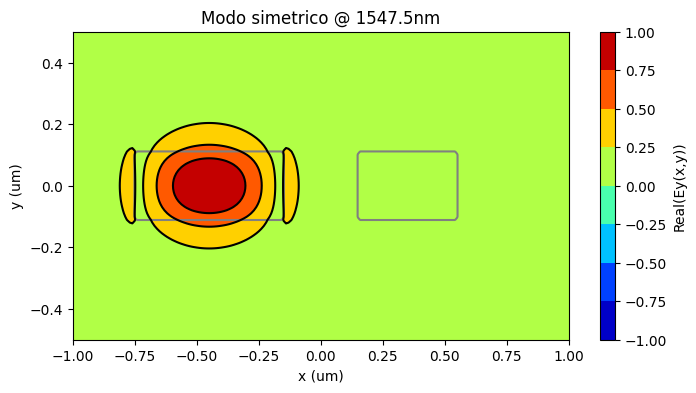

In [58]:
v = np.linspace(-1,1,9, endpoint = True)

fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(111)
X,Y = np.meshgrid(x_efielf, y_efielf)
plt.contour(X,Y,np.rot90(rfIndex.real),0, colors='gray', origin='upper')
plt.contour(X,Y,np.rot90(eField.real),v, colors='k', vmin=-1, vmax=1)
im = plt.contourf(X,Y, np.rot90(eField.real),v, cmap=plt.cm.jet, vmin=-1, vmax=1)

colorbar = plt.colorbar(im)
colorbar.set_ticks(v)
colorbar.set_label(r'Real(Ey(x,y))')
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.title(f'Modo simetrico @ 1547.5nm')
plt.xlim([-1,1])
plt.ylim([-0.5,0.5])

plt.savefig('symmetric_mode_300nm.png')

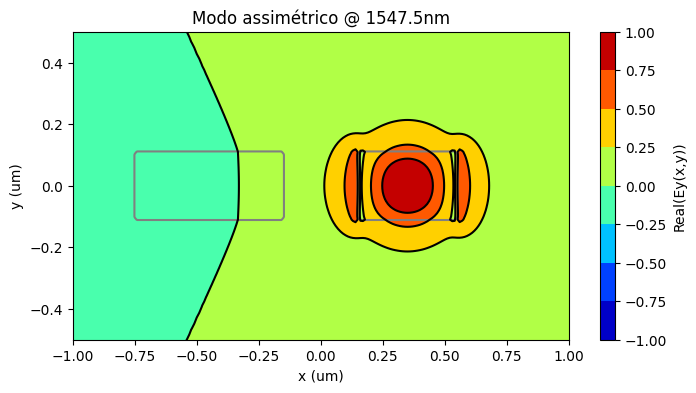

In [59]:
eField = np.squeeze(modeApi.getresult('FDE::data::mode2', 'Ex'))
x_efielf = modeApi.getresult('FDE::data::mode1', 'x')/um
y_efielf = modeApi.getresult('FDE::data::mode1', 'y')/um

rfIndex = np.squeeze(modeApi.getdata('FDE::data::material', 'index_y'))
v = np.linspace(-1,1,9, endpoint = True)

fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(111)
X,Y = np.meshgrid(x_efielf, y_efielf)
plt.contour(X,Y,np.rot90(rfIndex.real),0, colors='gray', origin='upper')
plt.contour(X,Y,np.rot90(eField.real),v, colors='k', vmin=-1, vmax=1)
im = plt.contourf(X,Y, np.rot90(eField.real),v, cmap=plt.cm.jet, vmin=-1, vmax=1)

colorbar = plt.colorbar(im)
colorbar.set_ticks(v)
colorbar.set_label(r'Real(Ey(x,y))')
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.title(f'Modo assimétrico @ 1547.5nm')
plt.xlim([-1,1])
plt.ylim([-0.5,0.5])

plt.savefig('assymmetric_mode_300nm.png')

In [60]:
n1 = modeApi.getresult('FDE::data::mode1', 'neff')
n2 = modeApi.getresult('FDE::data::mode2', 'neff')

In [61]:
modeApi.close()

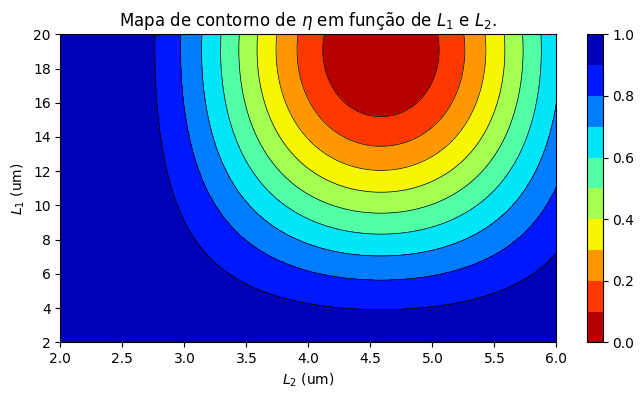

In [63]:
nplus = float(nplus.real)
nminus= float(nminus.real)
n1 = float(n1.real)
n2 = float(n2.real)
lambda0 = 1547.5*nm
deltaN = nplus - nminus
alpha = 2.7/1e2 #perda de 2.7dB/cm
L_t = 1e-6 #comprimento do taper
betaT1  = (2*np.pi*n1)/lambda0
betaT2  = (2*np.pi*n2)/lambda0

L1_values = np.linspace(2*um,20*um,100)
L2_values = np.linspace(2*um,6*um,100)
eta = np.zeros((len(L1_values), len(L2_values)))

for i, L1 in enumerate(L1_values):
    theta = np.pi*deltaN*L1/lambda0
    t = np.cos(theta)
    k = np.sin(theta)
    c = np.array([[t,-1j*k],
                  [-1j*k,t]])
    c *= np.exp(-1j*np.pi*(nplus+nminus)*L1/lambda0 - alpha*L1/2)
    
    P_t = np.diag([np.exp(-1j*betaT1*L_t), np.exp(-1j*betaT2*L_t)])
    for j, L2 in enumerate(L2_values):
        P = np.diag([np.exp(-1j*2*np.pi*n1*L2/lambda0),
                      np.exp(-1j*2*np.pi*n2*L2/lambda0)
                     ])
        M = c.dot(P_t).dot(P).dot(np.linalg.inv(P_t)).dot(c)
        E_out = M.dot(np.array([1,0]))
        eta[i,j] = np.abs(E_out[0])**2
X,Y = np.meshgrid(L2_values/um, L1_values/um)
fig, ax = plt.subplots(figsize=(8, 4))
cf = ax.contourf(X, Y, eta, levels=10, cmap='jet_r')
cs = ax.contour(X, Y, eta, levels=np.arange(0.1,1.0,0.1), colors='k', linewidths=0.5)
ax.set_title('Mapa de contorno de $\eta$ em função de $L_1$ e $L_2$.')
ax.set_xlabel('$L_2$ (um)')
ax.set_ylabel('$L_1$ (um)')
colorbar.ax.invert_yaxis()
fig.colorbar(cf)
plt.savefig('contour_map.png')